# Derivation of the stability landscape as the difference between probability density functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend import Legend

In [2]:
from scipy.stats import norm

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 11,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [5]:
# Function for kernel density estimation
def kde(x, x_grid, bandwidth = 0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # Returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)
#     return log_pdf

In [6]:
# Function to adjust hyperparameter by cross-validation
def hyperp(x, mn, mx, cv):
    bandwidths = 10 ** np.linspace(mn, mx, 50)
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv = cv)
    grid.fit(x[:, np.newaxis])
    return grid.best_params_

In [7]:
def pdf_normal(mean, std, x):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(- (x - mean)**2 / (2 * std**2))

Load data

In [8]:
df = pd.read_table('place/fine_all.tsv', index_col = 0)
df.shape

(5380, 28)

Standardize shapes

In [9]:
def ref_shape(s):
    """Reformat "shape column".
    """
    if 'shaped' in s:
        s = s.split('-')[0]
    elif s == 'sphere/spheroid':
        return 'sphere'
    elif s == 'rods':
        return 'rod'
    elif '/' in s:
        s = '-'.join(s.split('/'))
    if s in ('ovoid', 'oval', 'ellipsoidal'):
        return 'ovoid'
    elif s == 'pear':
        return 'sphere'
    elif s in ('sphere', 'spherical'):
        return 'sphere'
    else:
        return s

In [10]:
df['shape'] = df['shape'].fillna('').map(ref_shape)

Calculate V/S

In [11]:
df['vsratio'] = df['volume_gmean'] / df['surface_gmean']
df['log_vsratio'] = np.log10(df['vsratio'])

Fit data to normal distribution in log scale

In [12]:
data = df['log_vsratio'].values

In [13]:
parameters = norm.fit(data)

In [14]:
mu = parameters[0]
std = parameters[1]

Probability density funciton

In [15]:
x_grid = np.linspace(data.min(), data.max(), data.shape[0])
bw = hyperp(data, -1, 1, 5)
pdf = kde(data, x_grid, bandwidth = bw['bandwidth'])

In [16]:
pdf_n = norm.pdf(x_grid, parameters[0], parameters[1])

Figure

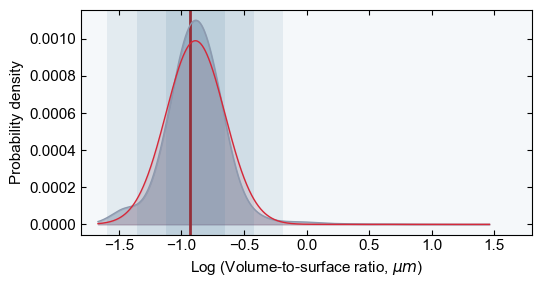

In [29]:
plt.figure(figsize = (5.55, 3))
    
# Values of PDF are normalized, such that they are tru probabilities
# and their sum gives one (i.e. a true probability!)
plt.plot(x_grid, pdf / pdf.sum(), color = '#8d99ae', lw = 1, zorder = 2)
plt.fill_between(x_grid, pdf / pdf.sum(), color = '#8d99ae', alpha = 0.5)
plt.plot(x_grid, pdf_n / pdf_n.sum(), color = '#d62839', linewidth = 1,
               linestyle = 'solid', zorder = 3)
plt.fill_between(x_grid, pdf_n / pdf_n.sum(), 
                 color = '#d62839', linewidth = 1, alpha = 0.1)
    
plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)')
plt.ylabel('Probability density')

# Optimum and std
plt.axvline(x = -0.93, color = '#bf0603', linestyle = 'solid', alpha = 1.0, linewidth = 2,
           zorder = 1)
for i in range(0, 4):
    low_r = mu + std * i
    up_r = mu + std * (i + 1)
    low_l = mu - std * i
    up_l = mu - std * (i + 1)
    if i == 3:
        up_r = 1.8
        up_l = -1.8
    plt.axvspan(low_r, up_r, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)
    plt.axvspan(low_l, up_l, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-1.8, 1.8)
plt.savefig('figures/stability_landscape_A.svg') 
plt.show()

Statbility landscape

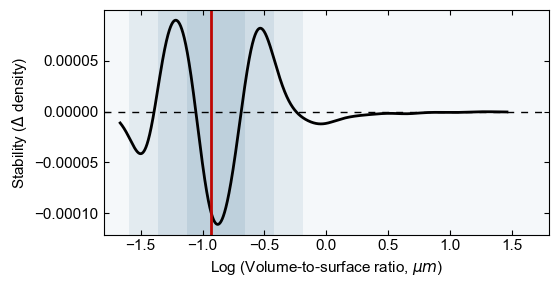

In [25]:
plt.figure(figsize = (5.72, 3))
plt.plot(x_grid, ((pdf_n / pdf_n.sum()) - (pdf / pdf.sum())), color = 'k',
        linewidth = 2)

# If both distributions were the same 
plt.axhline(y = 0, linestyle = (0, (5, 5)), linewidth = 1, color = 'k')
# Mean and std
plt.axvline(x = -0.93, color = '#bf0603', linestyle = 'solid', alpha = 1.0, linewidth = 2)
for i in range(0, 4):
    low_r = mu + std * i
    up_r = mu + std * (i + 1)
    low_l = mu - std * i
    up_l = mu - std * (i + 1)
    if i == 3:
        up_r = 1.8
        up_l = -1.8
    plt.axvspan(low_r, up_r, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)
    plt.axvspan(low_l, up_l, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-1.8, 1.8)

plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)', fontsize = 11)
plt.ylabel(f'Stability ($\\Delta$ density)', fontsize = 11)
plt.savefig('figures/stability_landscape_B.svg') 
plt.show()